# SYDE 522 Project Code
Chang Li, Maathusan Rajendram, Anastasia Santasheva, Evan Yeung

## Import Packages


In [23]:
# standard useful packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# validation & normalization methods
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# accuracy, MSE, log loss & timer methods
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from time import time

# dim reduction & classification methods 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# make matplotlib to show plots inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Set Configuration
* Select options for method validation
* Set parameters

In [24]:
# 1. set dataset
ENABLE_POR_DATA = False     # set Portugese course dataset
ENABLE_MAT_DATA = True    # set Math course dataset

# 2. set supervised approach for G3
ENABLE_BINARY_TARGET = True        # sets G3 to binary
ENABLE_5LEVEL_TARGET = False       # set G3 to five-level scale
ENABLE_REGRESSION_TARGET = False   # set G3 to current state for regression

# 3. set dimensionaltiy reduction method - set both to false for none
ENABLE_PCN = True
ENABLE_LDA = False

# 4. set validation type
ENABLE_KFOLD = True
ENABLE_LOO = True

# 5. set final test
ENABLE_TEST = False

## Load  Dataset
* Select a data set (Portugese course or Math course)

In [25]:
# import data from csv
if (ENABLE_POR_DATA):
    dataframe = pd.read_csv('student-por-train.csv', usecols = range(0,33)) 
    dataframe_test = pd.read_csv('student-por-test.csv', usecols = range(0,33)) 
elif (ENABLE_MAT_DATA): 
    dataframe = pd.read_csv('student-mat-train.csv', usecols = range(0,33))
    dataframe_test = pd.read_csv('student-mat-test.csv', usecols = range(0,33))

dataset = dataframe.values
dataset_test = dataframe_test.values
dataset.shape, dataset_test.shape

((316, 33), (79, 33))

## Preprocessing

* Convert nominal attributes with Integer + One-Hot Encoding
* Selects supervised approache for G3
* NOTE: if we want we can also split further into A,B,C (A= all cols, B=same as A without G2, C=same as B without G1)
    * But leaving this out for now since we know A gives best accuracy

In [26]:
# helper functions for preprocessing
def convertToBinary(df, num_cols):
    df.loc[(df.G3 < 10), 'G3'] = 0
    df.loc[(df.G3 >= 10), 'G3'] = 1
    
    G3 = df.values[:,num_cols-1]
    return G3

def convertToFiveLevel(df, num_cols):
    df.loc[(df.G3 <= 9), 'G3'] = 0
    df.loc[(df.G3 > 9) & (df.G3 <= 11), 'G3'] = 1
    df.loc[(df.G3 > 11) & (df.G3 <= 13), 'G3'] = 2
    df.loc[(df.G3 > 13) & (df.G3 <= 16), 'G3'] = 3
    df.loc[(df.G3 > 16), 'G3'] = 4
    
    G3 = df.values[:,num_cols-1]
    return G3   

def oneHotEncode(df, num_cols):
    df = df.drop(labels='G3', axis=1)
    cols_to_transform = [
                        'school',
                        'sex',
                        'address',
                        'famsize',
                        'Pstatus',
                        'Mjob',                        
                        'Fjob',
                        'reason',
                        'guardian',
                        'famsup',
                        'schoolsup',
                        'paid',
                        'activities',
                        'nursery',                        
                        'higher',
                        'internet',
                        'romantic',
                        ]
    hot_encoded_df = pd.get_dummies(df, columns = cols_to_transform)
    
    attributes = hot_encoded_df.values
    return attributes

def normalizeData(train_data, val_data):
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    val_data = scaler.transform(val_data)
    
    return train_data, val_data

# shuffle dataset
np.random.shuffle(dataset)

# find col length
num_cols = dataset.shape[1]

# labels of Y
labels = []

# split one-hot encoded attributes (X) and G3 (Y)
X = oneHotEncode(dataframe, num_cols)
X_tst = oneHotEncode(dataframe_test, num_cols)

# selects supervised approach for G3
if (ENABLE_BINARY_TARGET):
    Y = convertToBinary(dataframe, num_cols).astype('int')
    Y_tst = convertToBinary(dataframe_test, num_cols).astype('int')
    labels = [0, 1]
elif (ENABLE_5LEVEL_TARGET):
    Y = convertToFiveLevel(dataframe, num_cols).astype('int')
    Y_tst = convertToFiveLevel(dataframe_test, num_cols).astype('int')
    labels = [0, 1, 2, 3, 4]
elif (ENABLE_REGRESSION_TARGET):
    Y = dataset[:,num_cols-1].astype('int')
    Y_tst = dataset_test[:,num_cols-1].astype('int')
    

In [27]:
# Y
X.shape, Y.shape, X_tst.shape, Y_tst.shape

((316, 58), (316,), (79, 58), (79,))

## Dimensionality Reduction
* PCA & LDA reduction methods

In [28]:
def pcaReduction(train_data, val_data, n_comp):
    pca = PCA(n_components=n_comp)
    train_data = pca.fit_transform(train_data)
    val_data = pca.transform(val_data)
    
    return train_data, val_data

def ldaReduction(train_data, train_target, val_data, n_comp):
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    train_data = lda.fit_transform(train_data, train_target)
    val_data = lda.transform(val_data)
    
    return train_data, val_data


## Validation Methods
* k-Fold cross validation & Leave-one-out validation
* data gets normalized here

In [29]:
# method to calculate accuracy (PCC) & RMSE
def calcMetric(actual, predicted):
    if(ENABLE_REGRESSION_TARGET): return (mean_squared_error(actual, predicted))**(0.5) # calculates RMSE
    else: return accuracy_score(actual, predicted, normalize = True) # calculates PCC

def kFoldValidation(n_comp, penalty, n_splits=10):
    kFold = KFold(n_splits=n_splits)
    
    # run on validation data
    val_results = []
    train_results = []
    log_loss_results = []
    time_log = []
    
    for train_index, val_index in kFold.split(X):
        #start timer, return avg time below
        start = time()
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # normalize data
        X_train, X_val = normalizeData(X_train, X_val)
        
        # reduce dimensionality
        if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
        elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, penalty)
        
        predicted = clf.predict(X_val)
        val_accuracy = calcMetric(Y_val, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # log loss calculation - for classification only
        if(not ENABLE_REGRESSION_TARGET): log_loss_results.append(log_loss(Y_val, clf.predict_proba(X_val), labels=labels))
        
        val_results.append(val_accuracy)
        train_results.append(train_accuracy)
        time_log.append(time()-start)
        
    return np.mean(train_results, axis = 0), np.mean(val_results, axis = 0), np.mean(log_loss_results, axis = 0), np.mean(time_log, axis = 0)

def looValidation(n_comp, penalty):
    loo = LeaveOneOut()
    
    # run on validation data
    val_results = []
    train_results = []
    Y_test_prob = []
    log_loss_value = 0
    time_log = []
    
    for train_index, val_index in loo.split(X):
        #start timer, return avg time below
        start = time()
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # normalize data
        X_train, X_val = normalizeData(X_train, X_val)
        
        # reduce dimensionality
        if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
        elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, penalty)
        
        predicted = clf.predict(X_val)
        val_accuracy = calcMetric(Y_val, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # save probability for log loss calculation
        if(not ENABLE_REGRESSION_TARGET): Y_test_prob.append(clf.predict_proba(X_val)[0])
            
        test_results.append(test_accuracy)
        val_results.append(val_accuracy)
        train_results.append(train_accuracy)
        time_log.append(time()-start)
    
    # log loss calculation - for classification only
    if(not ENABLE_REGRESSION_TARGET): log_loss_value = log_loss(Y, Y_test_prob, labels=labels)

    return np.mean(train_results, axis = 0), np.mean(val_results, axis = 0), log_loss_value, np.mean(time_log, axis = 0)

## Classifier Selection
* Select classifer to validate

In [30]:
def getVotingClassifier():
    clf1 = SVC(C=10000, probability=True, kernel='rbf', gamma=0.0001)
    clf2 = RandomForestClassifier(n_estimators = 100, criterion = "entropy")
    clf3 = GaussianNB()

    return VotingClassifier(estimators=[('svm', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

# method to build classifier
def buildClf(train_data, train_target, penalty):
    
#     if(ENABLE_REGRESSION_TARGET):
#         model = SVR(C=0.0001, kernel='sigmoid', gamma=penalty) # for regression
#         model = SVR(C=penalty, kernel='linear') # for regression
#     else:
#         model = SVC(C=penalty, probability=True, kernel='linear')
#         model = getVotingClassifier()
#         model = GaussianNB()
#         model = MLPClassifier(solver = 'lbfgs')
#         model = DecisionTreeClassifier(max_depth = None, max_features = penalty, criterion = "entropy")
#         model = RandomForestClassifier(n_estimators = penalty, max_features=450, criterion = "entropy")
#         model = KNeighborsClassifier(n_neighbors=penalty, p=1)
#         model = BaggingClassifier(DecisionTreeClassifier(max_features = penalty, criterion = "entropy"), max_samples=0.5, max_features=6)
#     print("yes we are using ", penalty, " hidden layers")  
    model = MLPClassifier(activation='relu',
                                solver = 'lbfgs', # fixed
                                 hidden_layer_sizes=(penalty,) if penalty > 0 else (),
                                early_stopping=False,
                                max_iter=100) # fixed

### MLP Classifier Parameters ###
# activation='relu', 
# alpha=1e-05, 
# batch_size='auto',  
# beta_1=0.9, 
# beta_2=0.999, 
# early_stopping=False,
# epsilon=1e-08, 
# hidden_layer_sizes=(5, 2), 
# learning_rate='constant',    
# learning_rate_init=0.001, 
# max_iter=200, 
# momentum=0.9,
# nesterovs_momentum=True, 
# power_t=0.5, 
# random_state=1, 
# shuffle=True,      
# solver='lbfgs', 
# tol=0.0001, 
# validation_fraction=0.1, 
# verbose=False,      
# warm_start=False

    model.fit(train_data, train_target)
    return model

## Final Test Method
* Run best classifier on unseen test set

In [31]:
# get accuracy/RMSE, logloss and time 
def runTestSet(X_train, Y_train, X_test, Y_test, n_comp, penalty):
    
    start = time()
    test_log_loss = 0
    
    # normalize data
    X_train, X_test = normalizeData(X_train, X_test)

    # reduce dimensionality
    if (ENABLE_PCN): X_train, X_test = pcaReduction(X_train, X_test, n_comp)
    elif (ENABLE_LDA): X_train, X_test = ldaReduction(X_train, Y_train, X_test, n_comp)

    # build classifier, predict and get accuracy
    clf = buildClf(X_train, Y_train, penalty)
    predicted = clf.predict(X_test)
    test_accuracy = calcMetric(Y_test, predicted)
    
    # log loss calculation - for classification only
    if(not ENABLE_REGRESSION_TARGET): test_log_loss = log_loss(Y_test, clf.predict_proba(X_test))
        
    # execution time calculation
    test_time = time()-start
    
    return test_accuracy, test_log_loss, test_time

## Obtain Accuracy, Log Loss & Error
* Adjust array of penalty parameters
* Graphs error and log loss - for classification only

PCA n size:  5
0,0.005938959121704101,0.7528225806451614,,0.5052299728514794
2,0.029998469352722167,0.7465725806451613,,0.49959130538565616
4,0.03354523181915283,0.708366935483871,,0.5812473950241184
6,0.037656855583190915,0.7402217741935484,,0.6661406170237053
8,0.03988945484161377,0.6832661290322581,,0.7575924533814222
10,0.03848998546600342,0.7152217741935484,,0.7005052803979664
12,0.03932254314422608,0.702217741935484,,0.9136458954261318
14,0.04021387100219727,0.6803427419354839,,1.5168861458045755
16,0.040781831741333006,0.6897177419354839,,1.9881319682178433
18,0.042626166343688966,0.6961693548387096,,1.6130550345647148
20,0.04297189712524414,0.6831653225806452,,2.274781844254671
22,0.04427092075347901,0.6957661290322581,,3.3771371661892564
24,0.044039797782897946,0.7119959677419356,,3.5072595541696785
26,0.04583494663238526,0.6990927419354839,,4.214717030347584
28,0.04596402645111084,0.6806451612903226,,5.659963968683173
30,0.053904175758361816,0.6770161290322582,,5.240474596845

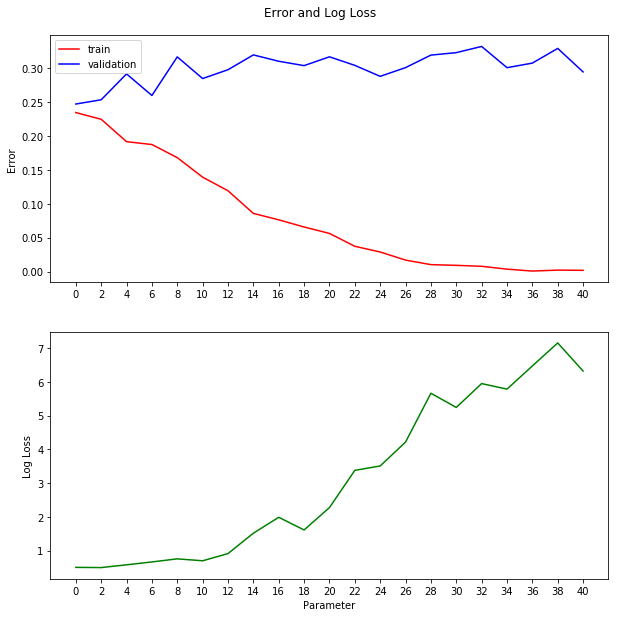

PCA n size:  10
0,0.009249281883239747,0.7618951612903226,,0.4989483339087804
2,0.04895517826080322,0.775100806451613,,0.47461783280584
4,0.03447501659393311,0.6925403225806452,,1.6027915030667512
6,0.039793086051940915,0.7246975806451613,,1.6007819171028494
8,0.06124205589294433,0.6959677419354838,,4.272540551904129
10,0.044742774963378903,0.6961693548387097,,8.31896991785802
12,0.04169509410858154,0.7056451612903226,,8.045860687515091
14,0.04248557090759277,0.677217741935484,,8.799583168988017
16,0.035729384422302245,0.7181451612903226,,8.0858465041602
18,0.04625866413116455,0.7024193548387097,,8.319897794862573
20,0.032436060905456546,0.7113911290322582,,7.317178401908353
22,0.03094332218170166,0.7087701612903227,,7.785748139169866
24,0.02577359676361084,0.7118951612903227,,7.6130135145445905
26,0.0274216890335083,0.7180443548387097,,7.341340832912832
28,0.025863385200500487,0.6934475806451614,,7.782197578091254
30,0.027112650871276855,0.6737903225806452,,7.6494830693949964
32,0.028

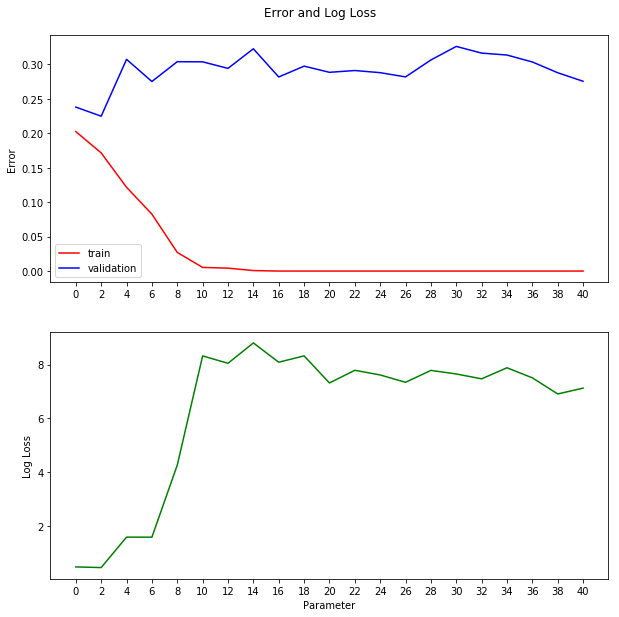

PCA n size:  30
0,0.009369325637817384,0.8610887096774194,,0.47415222499392956
2,0.05415430068969727,0.8225806451612904,,2.5196654500403795
4,0.015527105331420899,0.8229838709677418,,4.114367537772113
6,0.015028977394104004,0.8350806451612902,,3.330226446307548
8,0.016129207611083985,0.7880040322580646,,3.792896763456988
10,0.016666483879089356,0.807157258064516,,3.8091593870178535
12,0.01694810390472412,0.8194556451612904,,2.969036697005291
14,0.01739635467529297,0.826108870967742,,2.7448004199245934
16,0.018606853485107423,0.810282258064516,,3.1433873225226323
18,0.014424872398376466,0.8137096774193548,,2.6633750067502646
20,0.012852144241333009,0.8289314516129032,,2.830210031187596
22,0.015079069137573241,0.8230846774193548,,2.0971953312607465
24,0.018436694145202638,0.8355846774193548,,2.0374914618841697
26,0.015598487854003907,0.8071572580645162,,2.2616869071719607
28,0.013473916053771972,0.835483870967742,,2.412507309846482
30,0.016408157348632813,0.838508064516129,,2.04954942741

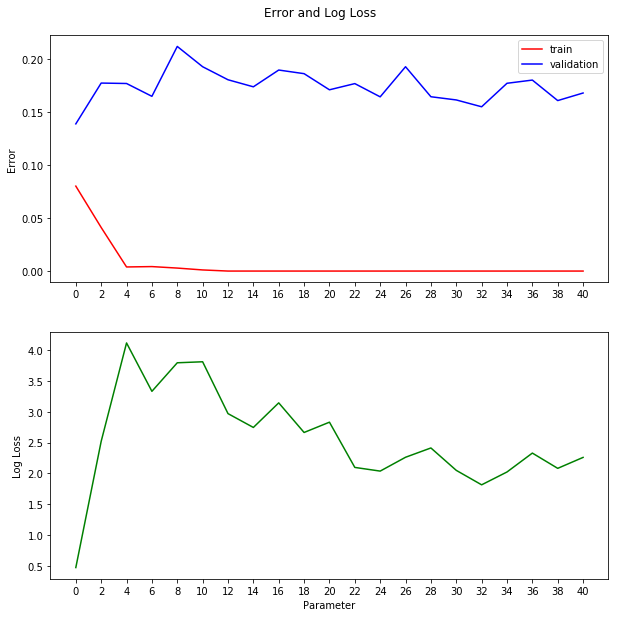

PCA n size:  40
0,0.02930588722229004,0.8826612903225806,,2.9481763896186783
2,0.024095940589904784,0.8383064516129032,,2.60351936525319
4,0.025608062744140625,0.844858870967742,,2.555886379867836
6,0.017256689071655274,0.8741935483870968,,2.603871680664686
8,0.021199560165405272,0.838608870967742,,2.469776894451695
10,0.013505291938781739,0.8924395161290322,,1.787121296918582
12,0.01366734504699707,0.8483870967741935,,1.943511459182379
14,0.011470198631286621,0.8638104838709678,,1.182937197607393
16,0.013886857032775878,0.8643145161290322,,1.2357178058661102
18,0.014812183380126954,0.8674395161290323,,1.081968742165578
20,0.017070627212524413,0.8387096774193548,,1.2453138488647697
22,0.013552975654602051,0.8736895161290322,,1.0661648270973856
24,0.013956570625305175,0.8705645161290322,,0.9168463718513813
26,0.013470292091369629,0.8608870967741936,,1.0327775635682444
28,0.014347529411315918,0.8485887096774194,,1.0045170401412522
30,0.013626885414123536,0.8704637096774194,,0.99833544131

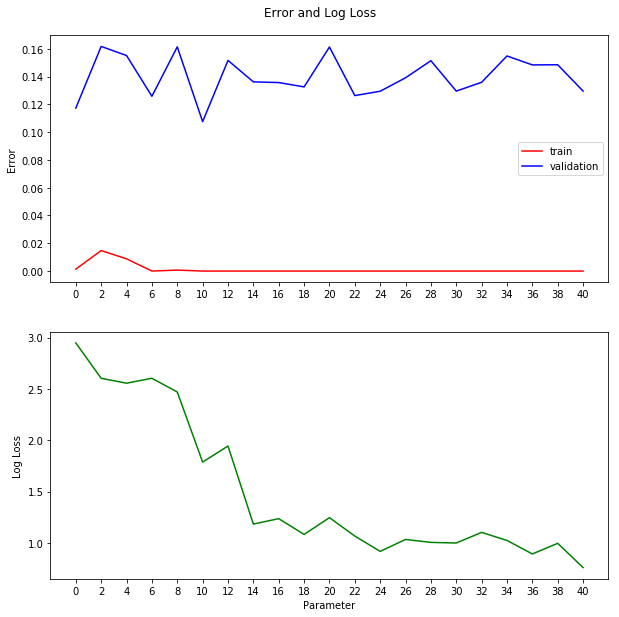

PCA n size:  45
0,0.0173168420791626,0.9080645161290322,,1.6545342157583818
2,0.03340160846710205,0.8413306451612904,,1.8903092793369347
4,0.025776314735412597,0.8577620967741936,,2.234709817956653
6,0.016850376129150392,0.8702620967741936,,2.278522844541855
8,0.015889072418212892,0.8672379032258064,,2.3683989013206443
10,0.012208962440490722,0.8574596774193548,,1.36004909506122
12,0.013010668754577636,0.8609879032258064,,1.4146255869043096
14,0.012980055809020997,0.8705645161290322,,1.1875820740443028
16,0.01393296718597412,0.8418346774193548,,1.3432177314763762
18,0.01495065689086914,0.8356854838709677,,1.164607373875839
20,0.016116690635681153,0.8419354838709678,,1.0031775470468172
22,0.012950325012207031,0.8642137096774194,,1.2499717247948412
24,0.013979887962341309,0.8513104838709677,,0.9796142715283601
26,0.01430656909942627,0.8675403225806452,,0.9546555985023909
28,0.015560460090637208,0.8642137096774194,,0.9507093418967616
30,0.018083906173706053,0.8767137096774194,,0.884209296

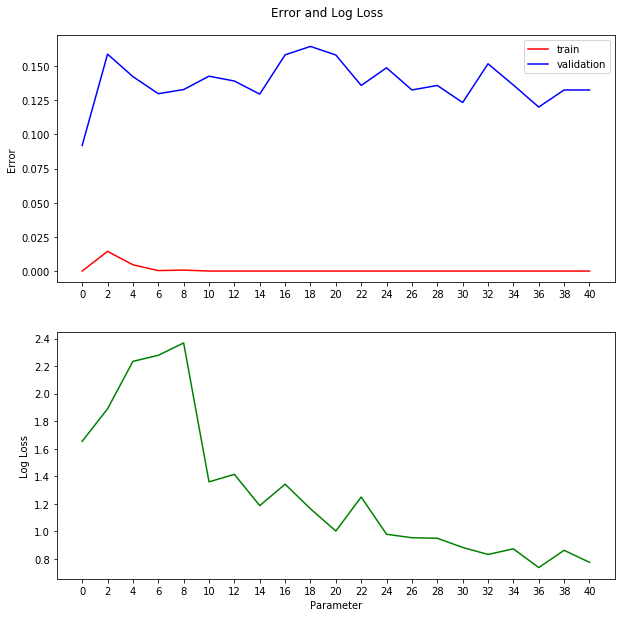

In [32]:
# input reduced dimension - this can be ignored if none selected
n_comp = 0
# n_size = [0]
n_size = [5, 10, 30, 40, 45]
for n in n_size:
    n_comp = n
    
    hyperparams = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40] # these are actually hidden layer nodes

    # input parameter iterations - can tune other params in classifer selection method above
    # if(not ENABLE_TEST):
    #     # hyperparams = [None]
    #     hyperparams = [1, 10, 100]
    # else: hyperparams = [10] # input best parameter for test

    # results array format: [[train], [validation], [log loss]]
    results = [[],[],[]]

    # calculate train error, test error, log loss & time for specific param
    print("PCA n size: ", n_comp)
    for penalty in hyperparams:

        if (ENABLE_KFOLD): train_res, val_res, log_loss_val, time_val = kFoldValidation(n_comp, penalty, 10)
        elif (ENABLE_LOO): train_res, val_res, log_loss_val, time_val = looValidation(n_comp, penalty)

        # save error, RMSE, log loss for each penalty for graph
        if (not ENABLE_REGRESSION_TARGET):
            results[0].append(1-train_res)
            results[1].append(1-val_res)
            results[2].append(log_loss_val)
        elif (ENABLE_REGRESSION_TARGET):
            results[0].append(train_res)
            results[1].append(val_res)

        print("{},{},{},{},{}".format(penalty, time_val, val_res, '', log_loss_val))
        #print ("-----C={}-----".format(penalty))
        #print ("Time: {} seconds".format(time_val))
        #print ("-----Train-----")
        #print ("Accuracy/RMSE: {}".format(train_res))
        #print ("-----Validation-----")
        #print ("Accuracy/RMSE: {}".format(val_res))
        #print ("Log Loss: {}\n".format(log_loss_val))



    # run best model on unseen test set
    if(ENABLE_TEST):
        test_accuracy, test_log_loss, test_time = runTestSet(X, Y, X_tst, Y_tst, n_comp, hyperparams[0])

        print ("-----Test-----")
        print ("Accuracy/RMSE: {}".format(test_accuracy))
        print ("Log Loss: {}".format(test_log_loss))
        print ("Time: {} seconds".format(test_time))

    # create error and log loss graph for penalty iterations - classification only
    if(not ENABLE_REGRESSION_TARGET and len(hyperparams) > 1):
        f, axarr = plt.subplots(2, sharex=False)
        f.suptitle('Error and Log Loss', y = 0.92)
        f.set_size_inches(10, 10)

        # subplot 1: error plot
        axarr[0].set_ylabel('Error')
        axarr[0].plot(hyperparams, results[0], color='r', label='train')
        axarr[0].plot(hyperparams, results[1], color='b', label='validation')
        axarr[0].set_xticks(hyperparams)
        axarr[0].legend()

        # subplot 2: log loss plot
        axarr[1].set_ylabel('Log Loss')
        axarr[1].plot(hyperparams, results[2], color='g', label='log loss')
        axarr[1].set_xticks(hyperparams)
        axarr[1].set_xlabel('Parameter')
        plt.show()

    # create RMSE graph for penalty iterations - regression only
    if(ENABLE_REGRESSION_TARGET and len(hyperparams) > 1):
        f, axarr = plt.subplots(sharex=False)
        f.suptitle('RMSE', y = 0.92)
        f.set_size_inches(10, 5)

        # subplot 1: RMSE plot
        axarr.set_ylabel('RMSE')
        axarr.plot(hyperparams, results[0], color='r', label='train')
        axarr.plot(hyperparams, results[1], color='b', label='validation')
        axarr.set_xticks(hyperparams)
        axarr.set_xlabel('Parameter')
        axarr.legend()
        plt.show()

## Ensemble Methods

In [33]:
Y

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1,